In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv('ObesityDataSet.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [28]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['NObeyesdad'] = label_encoder.fit_transform(df['NObeyesdad'])

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


In [14]:
from sklearn.model_selection import train_test_split

x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'MLP Classifier': MLPClassifier()
}


In [16]:
pipeline_models = {}
accuracy_scores = {}

for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model),
        ]
    )
    pipeline.fit(x_train, y_train)
    pipeline_models[name] = pipeline

    # fill accuracy
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy

C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:

df_models = pd.DataFrame(accuracy_scores.items(), columns=['model', 'score'])
df_models.head()

,model,score
0,Logistic Regression,0.872340
1,K-Nearest Neighbors,0.820331
2,Decision Tree,0.940898
3,Random Forest,0.936170
4,SVC,0.931442


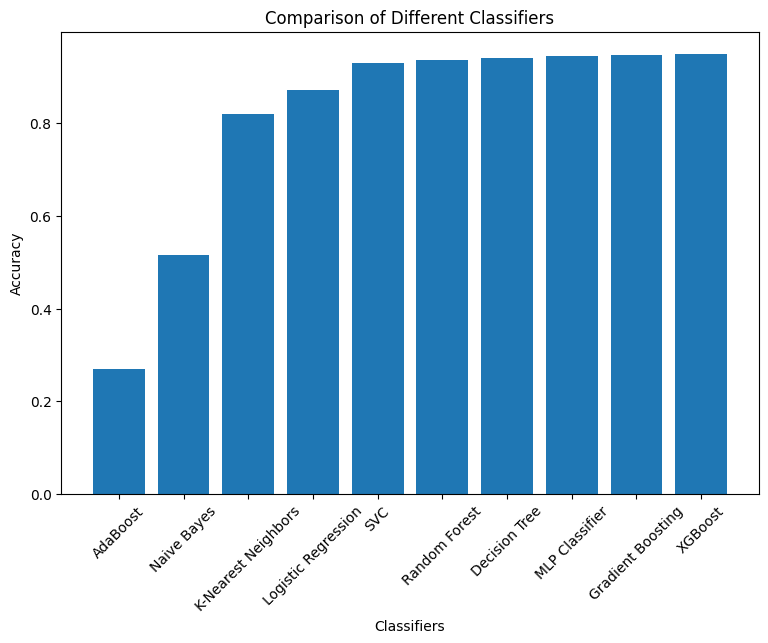

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.bar('model', 'score', data=df_models.sort_values('score'))
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.title('Comparison of Different Classifiers')
plt.xticks(rotation=45)
plt.show()


In [19]:
import pickle
import os

# Save each model separately
if not os.path.isdir('models'):
    os.makedirs('models')

for name, pipeline in pipeline_models.items():
    model = pipeline.named_steps['model']
    with open(f'models/{name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)


In [20]:
def predict_from_model(model_name, ind):
    loaded_pipeline = pipeline_models.get(model_name)
    if loaded_pipeline is None:
        print(f"Model '{model_name}' not found!")
        return

    data = x_test.iloc[ind:ind+1]
    real = y_test.iloc[ind]

    predictions = loaded_pipeline.predict(data)
    print("Predictions:", predictions)
    print("Real:", real)


In [21]:
# Choose the model to use for prediction
model_name = 'Logistic Regression'  # Choose the model name from the saved models
predict_from_model(model_name, 8)

Predictions: [2]
Real: 2


In [31]:
from flask import Flask, render_template, request
import pickle
import os

app = Flask(__name__)

def load_model(model_name):
    with open(os.path.join('models', f'{model_name}_model.pkl'), 'rb') as f:
        model = pickle.load(f)
    return model


# Classification page , GPT
@app.route('/classification', methods=['GET', 'POST'])
def classification():
    if request.method == 'POST':
        selected_model_name = request.form['model']
        selected_model = load_model(selected_model_name)
        
        # Get user input data from the form
        data = [request.form[col] for col in ['age', 'height', 'weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']]
        
        # Process the user input data and make predictions using the selected model
        prediction = selected_model.predict([data])  # Assuming selected_model is a trained model
        
        # Render the classification.html template with the selected model name and prediction
        return render_template('classification.html', selected_model_name=selected_model_name, prediction=prediction)
    else:
        # If it's a GET request, list all model files in the model folder and render the classification.html template
        model_files = os.listdir(MODEL_FOLDER)
        return render_template('classification.html', model_files=model_files)

# Model selection page
@app.route('/model_selection', methods=['GET', 'POST'])
def model_selection():
    if request.method == 'POST':
        # If the form is submitted, process the data and redirect to the classification page
        return render_template('model_selection.html')
    else:
        # If it's a GET request, render the model_selection.html template
        return render_template('model_selection.html')

# Model result page
@app.route('/model_result', methods=['GET', 'POST'])
def model_result():
    if request.method == 'POST':
        # If the form is submitted, process the data and render the model_result.html template
        return render_template('model_result.html')
    else:
        # If it's a GET request, render the model_result.html template
        return render_template('model_result.html')

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [14/May/2024 22:27:45] "GET /classification HTTP/1.1" 200 -


In [ ]:
from flask import Flask, render_template, request, redirect, url_for
import pickle
import os

app = Flask(__name__)


def load_model(model_name):
    with open(os.path.join('models', f'{model_name}_model.pkl'), 'rb') as f:
        model = pickle.load(f)
    return model

# Classification page
@app.route('/classification', methods=['GET', 'POST'])
def classification():
    if request.method == 'POST':
        # If the form is submitted, get the selected model name
        selected_model_name = request.form['model']
        # Load the selected model
        selected_model = load_model(selected_model_name)
        
        # Get user input data from the form
        data = [request.form[col] for col in ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']]
        
        # Check for missing values in the input data
        if None in data:
            return "Please fill in all fields before submitting the form."
        
        # Process the user input data and make predictions using the selected model
        prediction = selected_model.predict([data])[0]  # Assuming selected_model is a trained model
        
        # Redirect to the model result page with the prediction value
        return redirect(url_for('model_result', prediction=prediction))
    else:
        # If it's a GET request, list all model files in the model folder and render the classification.html template
        model_files = [file[:-10] for file in os.listdir(MODEL_FOLDER) if file.endswith('_model.pkl')]
        return render_template('classification.html', model_files=model_files)

# Model result page
@app.route('/model_result/<prediction>')
def model_result(prediction):
    return render_template('model_result.html', prediction=prediction)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/May/2024 13:44:30] "GET /classification HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2024 13:44:32] "GET /classification HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2024 13:44:34] "GET /classification HTTP/1.1" 200 -
[2024-05-15 13:45:07,250] ERROR in app: Exception on /classification [POST]
Traceback (most recent call last):
  File "C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Hatim\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 865, in dispatch